In [28]:
import numpy as np
import tensorflow as tf

np.random.seed(0)
tf.set_random_seed(0)

In [29]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [30]:
def xavier_init(fan_in, fan_out, constant = 1):
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out)) 
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval = low, maxval = high, dtype = tf.float32)

In [31]:
class VAE(object):
    def __init__(self, dim_input, dim_latent, hu, batch_size, learning_rate):
        self.dim_input = dim_input
        self.dim_latent = dim_latent
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # Input
        self.x = tf.placeholder(tf.float32, [None, dim_input])
        self.z_inj = tf.placeholder(tf.float32, [None, dim_latent])

        # Encoder
        self.z_mean, self.z_log_sigma_sq = self._encoder(dim_input, dim_latent, hu)
        
        # Decoder
        self.x_reconstr_mean = self._decoder(dim_input, dim_latent, hu)
        
        # Optimizer
        self._optimizer_sleep(learning_rate)
        self._optimizer_wake(learning_rate)
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
                       
    def _encoder(self, dim_input, dim_latent, n_hidden):
        hidden_w = tf.Variable(xavier_init(dim_input, n_hidden))
        hidden_b = tf.Variable(tf.zeros([n_hidden], dtype=tf.float32))
        out_mu_w = tf.Variable(xavier_init(n_hidden, dim_latent)) 
        out_mu_b = tf.Variable(tf.zeros([dim_latent], dtype=tf.float32))
        out_sigma_w = tf.Variable(xavier_init(n_hidden, dim_latent)) 
        out_sigma_b = tf.Variable(tf.zeros([dim_latent], dtype=tf.float32))
        
        hidden_layer = tf.nn.softplus(tf.add(tf.matmul(self.x, hidden_w), hidden_b))
        z_mean = tf.add(tf.matmul(hidden_layer, out_mu_w), out_mu_b)
        z_log_sigma_sq = tf.add(tf.matmul(hidden_layer, out_sigma_w), out_sigma_b)
        return z_mean, z_log_sigma_sq

    def _decoder(self, dim_input, dim_latent, n_hidden):
        hidden_w = tf.Variable(xavier_init(dim_latent, n_hidden))
        hidden_b = tf.Variable(tf.zeros([n_hidden], dtype=tf.float32))
        out_w = tf.Variable(xavier_init(n_hidden, dim_input)) 
        out_b = tf.Variable(tf.zeros([dim_input], dtype=tf.float32))
        
        hidden_layer = tf.nn.softplus(tf.add(tf.matmul(self.z_inj, hidden_w), hidden_b))
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(hidden_layer, out_w), out_b))
        return x_reconstr_mean
    
    def _optimizer_sleep(self, learning_rate):
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean), 1)
        self.cost_sleep = tf.reduce_mean(reconstr_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer_sleep = \
            tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost_sleep)
            
            
    def _optimizer_wake(self, learning_rate):        
        z_dist = tf.contrib.distributions.Normal(self.z_mean, tf.sqrt(tf.exp(self.z_log_sigma_sq)))
        latent_loss = -tf.reduce_sum(z_dist.log_pdf(self.z_inj), 1)
        self.cost_wake = tf.reduce_mean(latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer_wake = \
            tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost_wake)
        
    def partial_fit_sleep(self, X):
        z_to_inj = self.sess.run(self.z_mean, feed_dict={self.x: X})
        opt_sleep, cost_sleep = self.sess.run((self.optimizer_sleep, self.cost_sleep), 
                                  feed_dict={self.x: X, self.z_inj: z_to_inj})
        
        return cost_sleep
    
    def partial_fit_wake(self):
        z_to_inj = np.random.normal(size=(self.batch_size, self.dim_latent))
        x_recon = self.sess.run(self.x_reconstr_mean, feed_dict={self.z_inj: z_to_inj})
        opt_wake, cost_wake = self.sess.run((self.optimizer_wake, self.cost_wake), 
                                  feed_dict={self.x: x_recon, self.z_inj: z_to_inj})
        return cost_wake
    
    def encode_mean(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def encode_variational(self, X):
        return self.sess.run(self.z, feed_dict={self.x: X})
    
    def generate_prior(self):
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z_inj: z_mu})
    
    
    def generate_z(self, z_mu):
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z_inj: z_mu})

In [32]:
def train_model(data, epoch, latent_dim, hidden_units, batch_size, learning_rate):
    input_dim = data.train.images.shape[1]
    model = VAE(input_dim, latent_dim, hidden_units, batch_size, learning_rate)

    for e in range(epoch):
        avg_cost1 = 0.
        avg_cost2 = 0.
        total_batch = int(n_samples / batch_size)
        for i in range(total_batch):
            batch, _ = data.train.next_batch(batch_size)

            # Fit training using batch data
            cost1 = model.partial_fit_sleep(batch)
            cost2 = model.partial_fit_wake()
            # Compute average loss
            avg_cost1 += cost1 / n_samples * batch_size
            avg_cost2 += cost2 / n_samples * batch_size

        # Display logs per epoch step
        if (e % 1 == 0):
            print("Epoch:", '%04d' % (e+1), "cost1=", "{:.9f}".format(avg_cost1), "cost2=", "{:.9f}".format(avg_cost2))
    return model

In [33]:
model_2d = train_model(mnist, 70, 2, 500, 100, 0.001)    

Epoch: 0001 cost1= 201.185280651 cost2= 1.948603134
Epoch: 0002 cost1= 180.736953735 cost2= 1.844450827
Epoch: 0003 cost1= 178.994845359 cost2= 0.936415971
Epoch: 0004 cost1= 180.074460227 cost2= 0.142057444
Epoch: 0005 cost1= 180.787890847 cost2= 0.201260565
Epoch: 0006 cost1= 180.862973411 cost2= 1.208187849
Epoch: 0007 cost1= 180.885861483 cost2= 0.824813997
Epoch: 0008 cost1= 181.203861472 cost2= 0.666288172
Epoch: 0009 cost1= 181.180729537 cost2= 2.116614883
Epoch: 0010 cost1= 180.992671842 cost2= 0.663139154
Epoch: 0011 cost1= 181.015347512 cost2= 1.331906137
Epoch: 0012 cost1= 180.838065241 cost2= -0.162483448
Epoch: 0013 cost1= 180.732194436 cost2= -0.197249048
Epoch: 0014 cost1= 180.664518433 cost2= 1.017985556
Epoch: 0015 cost1= 180.611926270 cost2= 0.538735414
Epoch: 0016 cost1= 180.703065629 cost2= 0.547454582
Epoch: 0017 cost1= 180.627479026 cost2= 1.834701244
Epoch: 0018 cost1= 180.473606401 cost2= 2.019842662
Epoch: 0019 cost1= 180.849535800 cost2= 2.505948717
Epoch: 002

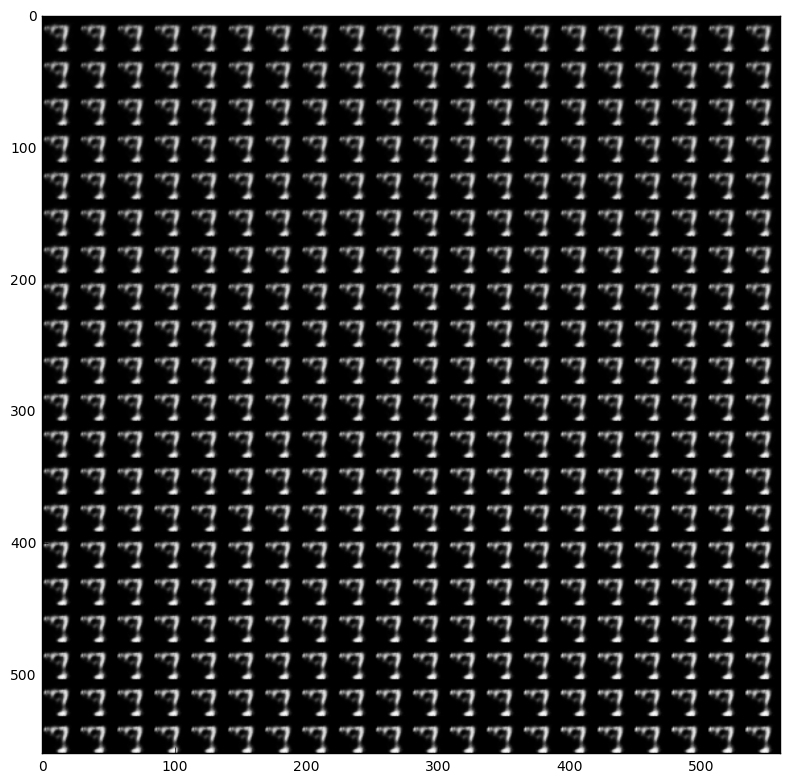

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*model_2d.batch_size)
        x_mean = model_2d.generate_z(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()